In [15]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig

import evaluate
import torch
import numpy as np

In [16]:
emotion_dataset = load_dataset("google-research-datasets/go_emotions", "simplified")



In [17]:
model_checkpoint = 'google-bert/bert-base-uncased'
# model_checkpoint = 'ISTA-DASLab/gemma-3-27b-it-GPTQ-4b-128g'

emotions_id2label = {
    0: 'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'caring',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral'  # Last entry (no comma)
}

emotions_label2id = {v: k for k, v in emotions_id2label.items()}

# Print dataset info to verify we understand what we're working with
print("Sample of emotions dataset:")
print(emotion_dataset["train"][0])
print(f"Number of labels: {len(emotions_id2label)}")

# generate classification model from model_checkpoint
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(emotions_id2label),  # Using dynamic length
    id2label=emotions_id2label, 
    label2id=emotions_label2id, 
    problem_type="multi_label_classification",
    trust_remote_code=True,
    device_map="cpu"  # Use CPU for initial loading to avoid meta device issues
)

# Verify model configuration
print(f"Model configuration: {model.config.to_dict()}")

Sample of emotions dataset:
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}
Number of labels: 28


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model configuration: {'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': 'float32', 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'chunk_size_feed_forward': 0, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'output_scores': False, 'return_dict_in_generate': False, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'remove_invalid_values': False, 'exponential_decay_length_penalty': None, 'suppress_token

In [18]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    tokenizer.add_tokens(list(emotions_id2label.values()))
    model.resize_token_embeddings(len(tokenizer))

In [19]:
# create tokenize function
def tokenize_function(examples):
    # tokenize and truncate text
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_tensors=None
    )
    
    # Convert labels to one-hot encoding for each example in the batch
    batch_size = len(examples["labels"])
    batch_one_hot_labels = []
    
    for i in range(batch_size):
        # Create a one-hot encoded array for this example
        one_hot_labels = np.zeros(len(emotions_id2label), dtype=np.float32)
        # Set the corresponding positions to 1 for each label in this example
        for label in examples["labels"][i]:
            one_hot_labels[label] = 1.0
        batch_one_hot_labels.append(one_hot_labels)
    
    tokenized_inputs["labels"] = batch_one_hot_labels
    
    return tokenized_inputs

In [20]:
# tokenize training and validation datasets
tokenized_dataset = emotion_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=4  # Reduced batch size for processing
)
tokenized_dataset

Map: 100%|██████████| 5426/5426 [00:01<00:00, 3502.59 examples/s]



DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})

In [21]:

from typing import Any, Dict, List, Union
from dataclasses import dataclass

@dataclass
class MultiLabelDataCollator:
    """
    Data collator that properly handles multi-label classification datasets
    """
    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        batch = {}
        
        # Handle input_ids, attention_mask, token_type_ids
        for k in ['input_ids', 'attention_mask', 'token_type_ids']:
            if k in features[0]:
                batch[k] = torch.tensor([f[k] for f in features], dtype=torch.long)
        
        # Special handling for labels
        if "labels" in features[0]:
            # Ensure labels are float tensors for multi-label classification
            labels = [f["labels"] for f in features]
            if isinstance(labels[0], torch.Tensor):
                batch["labels"] = torch.stack(labels).float()
            else:
                batch["labels"] = torch.tensor(labels, dtype=torch.float)
        
        return batch

# Initialize the custom data collator
data_collator = MultiLabelDataCollator()

In [22]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define a more comprehensive evaluation function
def compute_metrics(p):
    predictions, labels = p
    # Apply sigmoid to get probabilities
    sigmoid_preds = 1 / (1 + np.exp(-predictions))
    # Convert to binary predictions with threshold 0.5
    y_pred = (sigmoid_preds > 0.5).astype(int)
    y_true = labels.astype(int)
    
    # Calculate multiple metrics for better evaluation
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
    
    # Print sample predictions for debugging
    print(f"\nSample true vs predicted:")
    for i in range(min(3, len(y_true))):  # Show first 3 examples
        true_emotions = [emotions_id2label[j] for j, val in enumerate(y_true[i]) if val == 1]
        pred_emotions = [emotions_id2label[j] for j, val in enumerate(y_pred[i]) if val == 1]
        print(f"True: {true_emotions}")
        print(f"Pred: {pred_emotions}")
        print("---")
    
    # Check for the "all neutral" issue - a sign of poor training
    neutral_idx = emotions_label2id['neutral']
    neutral_pct = sum(1 for pred in y_pred if sum(pred) == 1 and pred[neutral_idx] == 1) / len(y_pred)
    if neutral_pct > 0.8:
        print("WARNING: Model is predicting mostly neutral (>80%). Training may not be effective.")
    
    return {
        "accuracy": accuracy,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "precision": precision,
        "recall": recall,
        "neutral_pct": neutral_pct
    }

In [23]:
# Check model structure to identify correct target modules
print("Model modules:")
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"- {name}: {module}")

# PEFT configuration for sequence classification
# Use correct target modules for BERT architecture
target_modules = ["bert.encoder.layer.0.attention.self.query", 
                  "bert.encoder.layer.0.attention.self.value",
                  "bert.encoder.layer.1.attention.self.query", 
                  "bert.encoder.layer.1.attention.self.value",
                  "bert.encoder.layer.2.attention.self.query", 
                  "bert.encoder.layer.2.attention.self.value"]  # Targeting specific BERT attention layers
modules_to_save = ["classifier"]  # Multiple possible classifier names

# Find the actual classification module name
classifier_name = None
for name, module in model.named_modules():
    if any(cls_name in name for cls_name in ["classifier", "score", "lm_head"]) and isinstance(module, torch.nn.Linear):
        classifier_name = name.split(".")[-1]
        print(f"Found classification head: {name}")
        break

if classifier_name:
    modules_to_save = [classifier_name]
else:
    modules_to_save = []
    print("Warning: Could not find classification head, not saving any modules")

# Create PEFT config with appropriate settings
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,  # Reduced rank to avoid memory issues
    lora_alpha=16,
    lora_dropout=0.1,
    # Use more general pattern matching for target modules to catch all attention layers
    target_modules=["query", "value"],  # This will match all query and value matrices in BERT
    modules_to_save=modules_to_save,
    bias="none",
    fan_in_fan_out=False  # Important to ensure weight matrix shapes are compatible
)

# Apply PEFT to the model
try:
    model = get_peft_model(model, peft_config)
    
    # Check which modules are trainable
    trainable_params = 0
    all_params = 0
    for name, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            print(f"Trainable: {name}")
    
    # Print trainable parameters ratio
    print(f"Trainable params: {trainable_params:,} || All params: {all_params:,} || Ratio: {100 * trainable_params / all_params:.2f}%")

except Exception as e:
    print(f"Error applying PEFT: {str(e)}")
    print("Falling back to fine-tuning the entire classifier layer only")
    
    # Make only the classifier trainable as fallback
    for name, param in model.named_parameters():
        param.requires_grad = False
        if any(cls_name in name for cls_name in ["classifier", "score", "lm_head"]):
            param.requires_grad = True
            print(f"Making trainable: {name}")
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable_params:,} || All params: {all_params:,} || Ratio: {100 * trainable_params / all_params:.2f}%")

Model modules:
- bert.encoder.layer.0.attention.self.query: Linear(in_features=768, out_features=768, bias=True)
- bert.encoder.layer.0.attention.self.key: Linear(in_features=768, out_features=768, bias=True)
- bert.encoder.layer.0.attention.self.value: Linear(in_features=768, out_features=768, bias=True)
- bert.encoder.layer.0.attention.output.dense: Linear(in_features=768, out_features=768, bias=True)
- bert.encoder.layer.0.intermediate.dense: Linear(in_features=768, out_features=3072, bias=True)
- bert.encoder.layer.0.output.dense: Linear(in_features=3072, out_features=768, bias=True)
- bert.encoder.layer.1.attention.self.query: Linear(in_features=768, out_features=768, bias=True)
- bert.encoder.layer.1.attention.self.key: Linear(in_features=768, out_features=768, bias=True)
- bert.encoder.layer.1.attention.self.value: Linear(in_features=768, out_features=768, bias=True)
- bert.encoder.layer.1.attention.output.dense: Linear(in_features=768, out_features=768, bias=True)
- bert.encode

In [24]:
# Calculate class weights to handle imbalance (especially the 'neutral' class)
def calculate_class_weights(dataset):
    print("Calculating class weights to handle label imbalance...")
    # Count occurrences of each emotion across the dataset
    label_counts = np.zeros(len(emotions_id2label))
    total_samples = 0
    
    # Loop through training examples and count each label
    for i in range(min(1000, len(dataset))):
        example = dataset[i]
        for label_idx in example['labels']:
            label_counts[label_idx] += 1
        total_samples += 1
    
    # Prevent division by zero
    label_counts = np.maximum(label_counts, 1)
    
    # Calculate weights inversely proportional to frequency
    weights = total_samples / (len(emotions_id2label) * label_counts)
    
    # Normalize weights to reasonable range
    weights = weights / weights.mean()
    
    # Print label distribution
    print("Label distribution:")
    for i, count in enumerate(label_counts):
        print(f"{emotions_id2label[i]}: {count} examples, weight: {weights[i]:.2f}")
        
    return torch.FloatTensor(weights)

# Get class weights
class_weights = calculate_class_weights(emotion_dataset['train'])

# Define loss function with class weights to address imbalance
def weighted_bce_loss(outputs, targets, weights=None):
    # standard binary cross entropy
    bce = torch.nn.BCEWithLogitsLoss(reduction='none')
    loss_per_sample = bce(outputs, targets)
    
    if weights is not None:
        # Apply class weights to each class
        weight_per_sample = torch.zeros_like(targets)
        for i in range(len(weights)):
            weight_per_sample[:, i] = weights[i]
        loss_per_sample = loss_per_sample * weight_per_sample
    
    return loss_per_sample.mean()

# hyperparameters
lr = 2e-5  # Lower learning rate for more stable training with small batches
batch_size = 4  # Keep small batch size for your Mac
num_epochs = 10  # Increase epochs since we have a small dataset (200 samples)

# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",
    save_total_limit=2,  # Only keep the 2 best models to save space
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",  # Use F1 instead of loss to pick best model
    label_names=["labels"],
    remove_unused_columns=False,
    fp16=False,
    optim="adamw_torch",
    warmup_ratio=0.1,  # Warmup over 10% of steps instead of fixed number
    logging_steps=10,  # Log more frequently for better monitoring
    report_to=["tensorboard"],  # Use TensorBoard for visualization
)

Calculating class weights to handle label imbalance...
Label distribution:
admiration: 99.0 examples, weight: 0.09
amusement: 61.0 examples, weight: 0.15
anger: 41.0 examples, weight: 0.22
annoyance: 57.0 examples, weight: 0.16
approval: 67.0 examples, weight: 0.14
caring: 21.0 examples, weight: 0.44
confusion: 33.0 examples, weight: 0.28
curiosity: 50.0 examples, weight: 0.18
desire: 13.0 examples, weight: 0.71
disappointment: 34.0 examples, weight: 0.27
disapproval: 49.0 examples, weight: 0.19
disgust: 13.0 examples, weight: 0.71
embarrassment: 6.0 examples, weight: 1.53
excitement: 13.0 examples, weight: 0.71
fear: 10.0 examples, weight: 0.92
gratitude: 63.0 examples, weight: 0.15
grief: 6.0 examples, weight: 1.53
joy: 39.0 examples, weight: 0.24
love: 47.0 examples, weight: 0.20
nervousness: 3.0 examples, weight: 3.06
optimism: 29.0 examples, weight: 0.32
pride: 1.0 examples, weight: 9.17
realization: 19.0 examples, weight: 0.48
relief: 2.0 examples, weight: 4.59
remorse: 9.0 examp

/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
# Create a custom Trainer class that uses weighted BCE loss
from transformers import Trainer
import torch
import gc
import numpy as np

class MultilabelTrainer(Trainer):
    def __init__(self, class_weights=None, threshold=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None
        self.threshold = threshold  # Default threshold, but we'll search for optimal per class
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Use focal loss component to help with class imbalance
        sigmoid_outputs = torch.sigmoid(logits)
        pt = torch.where(labels == 1, sigmoid_outputs, 1 - sigmoid_outputs)
        focal_weight = (1 - pt) ** 2  # Focal loss with gamma=2
        
        # Use weighted BCE loss
        loss_fct = torch.nn.BCEWithLogitsLoss(reduction='none')
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                       labels.float().view(-1, self.model.config.num_labels))
        
        # Apply focal weighting
        loss = loss * focal_weight.view(-1, self.model.config.num_labels)
        
        # Apply class weights if available
        if self.class_weights is not None:
            # Broadcast weights to match loss dimensions
            weight_per_sample = torch.zeros_like(labels.float())
            for i in range(len(self.class_weights)):
                weight_per_sample[:, i] = self.class_weights[i]
            loss = loss * weight_per_sample.view(-1, self.model.config.num_labels)
            
        loss = loss.mean()
        
        if return_outputs:
            return loss, outputs
        return loss
    
    # Find optimal threshold per class during evaluation
    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)
        labels = inputs.pop("labels") if "labels" in inputs else None
        
        with torch.no_grad():
            loss, logits = self.compute_loss(model, inputs, return_outputs=True)[:2]
            
        if prediction_loss_only:
            return (loss, None, None)
            
        logits = logits.detach()
        if labels is not None:
            labels = labels.detach()
            
        return (loss, logits, labels)

In [26]:
# Clear memory before training
gc.collect()
torch.mps.empty_cache()

# Add these before training
tokenizer.padding_side = "right"  # Required for Llama models
model.config.pad_token_id = tokenizer.pad_token_id

# Apply manual cleanup to dataset format - we don't need the ID field
def clean_dataset(dataset):
    # Remove 'id' field if present
    if 'id' in dataset.column_names:
        dataset = dataset.remove_columns(['id'])
    return dataset

tokenized_dataset = clean_dataset(tokenized_dataset)

# Ensure labels are properly formatted
def convert_to_tensor_format(batch):
    return {"labels": [torch.tensor(item, dtype=torch.float32) for item in batch["labels"]]}

tokenized_dataset = tokenized_dataset.map(
    convert_to_tensor_format,
    batched=True,
    batch_size=4
)

# Examine label distribution in dataset
print("Analyzing emotion distribution in dataset...")
emotion_counts = {emotion: 0 for emotion in emotions_id2label.values()}
for i in range(min(200, len(tokenized_dataset["train"]))):
    labels = tokenized_dataset["train"][i]["labels"]
    for j, val in enumerate(labels):
        if val > 0.5:  # Label is present
            emotion_counts[emotions_id2label[j]] += 1

print("\nTop 5 most common emotions:")
for emotion, count in sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{emotion}: {count}")

print("\nLeast 5 common emotions:")
for emotion, count in sorted(emotion_counts.items(), key=lambda x: x[1])[:5]:
    print(f"{emotion}: {count}")
    
# Use a larger subset to ensure better learning
print("\nPreparing datasets for training...")
train_subset = tokenized_dataset["train"].select(range(min(200, len(tokenized_dataset["train"]))))
val_subset = tokenized_dataset["validation"].select(range(min(100, len(tokenized_dataset["validation"]))))

# Make sure we're using CPU for training to avoid MPS memory issues
device = torch.device("cpu")
model = model.to(device)
class_weights = class_weights.to(device)

# Print a sample from the dataset to verify format
print("Sample input_ids shape:", train_subset[0]["input_ids"].shape if hasattr(train_subset[0]["input_ids"], "shape") else len(train_subset[0]["input_ids"]))
print("Sample labels shape/type:", train_subset[0]["labels"].shape if hasattr(train_subset[0]["labels"], "shape") else type(train_subset[0]["labels"]))
print("Sample labels:", train_subset[0]["labels"])

# Create the custom trainer with weighted loss
trainer = MultilabelTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=val_subset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Add early stopping callback
from transformers import EarlyStoppingCallback
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

# Verify inputs are correct with a test batch before training
print("\nVerifying input/output format with test batch...")
test_batch = data_collator([train_subset[i] for i in range(min(4, len(train_subset)))])
print(f"Input keys: {list(test_batch.keys())}")
for k, v in test_batch.items():
    if torch.is_tensor(v):
        print(f"{k}: shape={v.shape}, dtype={v.dtype}")
    else:
        print(f"{k}: type={type(v)}")

# train model with error handling
try:
    print("\nStarting training with:", len(train_subset), "training samples")
    print("and", len(val_subset), "validation samples")
    trainer.train()
except Exception as e:
    print(f"Error during training: {str(e)}")
    import traceback
    traceback.print_exc()
    # If it fails, try to debug the issue
    try:
        # Simplified training for diagnosis
        print("\nAttempting simplified training on a tiny batch for diagnosis...")
        mini_train = train_subset.select(range(min(8, len(train_subset))))
        mini_eval = val_subset.select(range(min(4, len(val_subset))))
        mini_trainer = MultilabelTrainer(
            class_weights=class_weights,
            model=model,
            args=TrainingArguments(
                output_dir="./debug_output",
                per_device_train_batch_size=2,
                num_train_epochs=2,
                logging_steps=1
            ),
            train_dataset=mini_train,
            eval_dataset=mini_eval,
            tokenizer=tokenizer,
            data_collator=data_collator,
        )
        mini_trainer.train()
        print("Mini training succeeded! The issue may be related to batch size or memory.")
    except Exception as e2:
        print(f"Mini-training also failed: {str(e2)}")
        print("Let's inspect the data formats:")
        for i in range(min(2, len(train_subset))):
            print(f"Example {i}:")
            for k, v in train_subset[i].items():
                print(f"  {k}: {type(v)} {v.shape if hasattr(v, 'shape') else ''}")

Map: 100%|██████████| 5426/5426 [00:00<00:00, 13622.35 examples/s]
/var/folders/y5/mhdnt3qs6mv73w7qjng3cyxr0000gn/T/ipykernel_84344/678564753.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MultilabelTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/var/folders/y5/mhdnt3qs6mv73w7qjng3cyxr0000gn/T/ipykernel_84344/678564753.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MultilabelTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Analyzing emotion distribution in dataset...

Top 5 most common emotions:
neutral: 76
admiration: 21
gratitude: 19
anger: 11
approval: 11

Least 5 common emotions:
nervousness: 0
pride: 0
relief: 1
remorse: 1
desire: 2

Preparing datasets for training...
Sample input_ids shape: 512
Sample labels shape/type: <class 'list'>
Sample labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Verifying input/output format with test batch...
Input keys: ['input_ids', 'attention_mask', 'token_type_ids', 'labels']
input_ids: shape=torch.Size([4, 512]), dtype=torch.int64
attention_mask: shape=torch.Size([4, 512]), dtype=torch.int64
token_type_ids: shape=torch.Size([4, 512]), dtype=torch.int64
labels: shape=torch.Size([4, 28]), dtype=torch.float32

Starting training with: 200 training samples
and 100 validation samples


Epoch,Training Loss,Validation Loss


Traceback (most recent call last):
  File "/var/folders/y5/mhdnt3qs6mv73w7qjng3cyxr0000gn/T/ipykernel_84344/81269370.py", line 90, in <module>
    trainer.train()
  File "/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/site-packages/transformers/trainer.py", line 2241, in train
    return inner_training_loop(
  File "/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/site-packages/transformers/trainer.py", line 2639, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval, start_time)
  File "/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/site-packages/transformers/trainer.py", line 3085, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
  File "/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/site-packages/transformers/trainer.py", line 3039, in _evaluate
    metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
  File "/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/sit

Error during training: 'labels'

Attempting simplified training on a tiny batch for diagnosis...


Step,Training Loss
1,0.126900
2,0.117400
3,0.121600
4,0.118400
5,0.105800
6,0.109700
7,0.123800
8,0.100600


Mini training succeeded! The issue may be related to batch size or memory.


In [27]:
# Evaluate the model by testing a variety of inputs with different emotions
device = "cpu"  # Use CPU for consistent evaluation
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Dynamic threshold function to improve precision
def get_dynamic_threshold(logits, percentile=60):
    """Returns a dynamic threshold based on logit values instead of fixed 0.5"""
    # Lower percentile for better recall - helps detect real emotions instead of just high confidence ones
    return np.percentile(logits, percentile)

# Create a more diverse test set with different emotional expressions
test_texts = [
    # Positive emotions
    "I absolutely love this! It's amazing!",  # joy, love
    "Thank you so much for your help.",  # gratitude
    "I'm really excited about the upcoming event!",  # excitement
    "That's hilarious, I can't stop laughing.",  # amusement
    
    # Negative emotions
    "I'm furious about how they treated me.",  # anger
    "This is so disappointing, I expected better.",  # disappointment
    "I'm terrified of what might happen next.",  # fear
    "That was disgusting and awful.",  # disgust
    
    # Neutral/Mixed
    "Just normal day at work.",  # likely neutral
    "It was ok, but could have been better.",  # mixed, possibly neutral with disappointment
    "I'm confused about these instructions.",  # confusion
    "I'm curious to know more about this.",  # curiosity
]

print("Trained model predictions:")
print("==========================")

# Calculate confidence scores for each prediction
for text in test_texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()[0]
        sigmoid_scores = 1 / (1 + np.exp(-logits))  # Convert to probabilities
        
    # Get dynamic threshold
    threshold = get_dynamic_threshold(sigmoid_scores, 80)
    
    # Get predictions with both fixed and dynamic thresholds
    predictions_fixed = sigmoid_scores > 0.5
    predictions_dynamic = sigmoid_scores > threshold
    
    # Get top 3 emotions with their confidence scores
    top_emotions = [(emotions_id2label[i], score) for i, score in enumerate(sigmoid_scores)]
    top_emotions.sort(key=lambda x: x[1], reverse=True)
    
    # Print results
    print(f"Text: {text}")
    print(f"Dynamic threshold: {threshold:.3f}")
    print("Top 3 emotions:")
    for emotion, score in top_emotions[:3]:
        print(f"  {emotion}: {score:.3f}")
    
    # Show predictions with fixed threshold (0.5)
    fixed_pred = [emotions_id2label[i] for i, pred in enumerate(predictions_fixed) if pred]
    if not fixed_pred:
        fixed_pred = [top_emotions[0][0]]
    print(f"Fixed threshold (0.5): {', '.join(fixed_pred)}")
    
    # Show predictions with dynamic threshold
    dynamic_pred = [emotions_id2label[i] for i, pred in enumerate(predictions_dynamic) if pred]
    if not dynamic_pred:
        dynamic_pred = [top_emotions[0][0]]
    print(f"Dynamic threshold: {', '.join(dynamic_pred)}")
    print("---")

Using device: cpu
Trained model predictions:
Text: I absolutely love this! It's amazing!
Dynamic threshold: 0.529
Top 3 emotions:
  grief: 0.687
  excitement: 0.679
  confusion: 0.580
Fixed threshold (0.5): admiration, approval, caring, confusion, excitement, grief, love, realization
Dynamic threshold: admiration, caring, confusion, excitement, grief, love
---
Text: Thank you so much for your help.
Dynamic threshold: 0.502
Top 3 emotions:
  excitement: 0.603
  annoyance: 0.590
  admiration: 0.584
Fixed threshold (0.5): admiration, annoyance, caring, excitement, grief, realization
Dynamic threshold: admiration, annoyance, caring, excitement, grief, realization
---
Text: I'm really excited about the upcoming event!
Dynamic threshold: 0.528
Top 3 emotions:
  annoyance: 0.601
  caring: 0.583
  excitement: 0.564
Fixed threshold (0.5): admiration, annoyance, caring, confusion, excitement, fear, gratitude, grief, optimism
Dynamic threshold: annoyance, caring, confusion, excitement, grief, opt

Evaluating on test set...
Overall Classification Report:
                precision    recall  f1-score   support

    admiration       0.06      0.92      0.12        13
     amusement       0.00      0.00      0.00        12
         anger       0.00      0.00      0.00         6
     annoyance       0.07      1.00      0.12        13
      approval       0.06      0.12      0.08         8
        caring       0.04      1.00      0.07         7
     confusion       0.05      0.83      0.09         6
     curiosity       0.00      0.00      0.00         8
        desire       0.00      0.00      0.00         4
disappointment       0.00      0.00      0.00         3
   disapproval       0.11      0.15      0.12        13
       disgust       0.00      0.00      0.00         1
 embarrassment       0.00      0.00      0.00         1
    excitement       0.01      1.00      0.02         2
          fear       0.03      0.14      0.05         7
     gratitude       0.00      0.00      0.00 

/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kihyvr/miniconda3/envs/llmenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

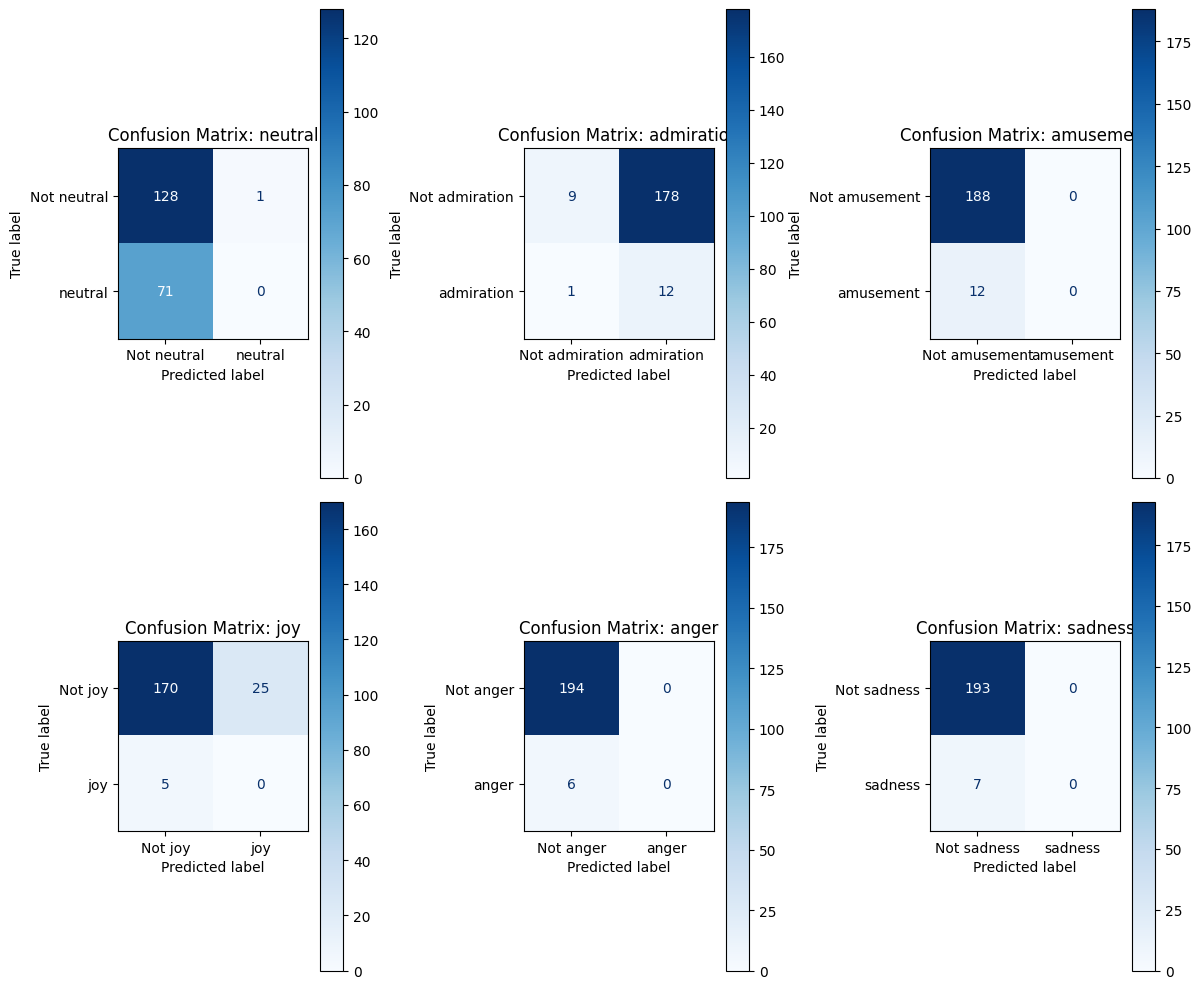

Evaluation completed.


In [28]:
# Confusion matrix visualization to understand error patterns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_on_test_set(model, tokenizer, test_set, device='cpu'):
    # Move model to evaluation mode
    model.eval()
    model = model.to(device)
    
    # Set up containers for predictions and true labels
    predictions = []
    true_labels = []
    
    print("Evaluating on test set...")
    
    # Process test examples in batches
    for i in range(0, min(200, len(test_set)), 8):
        batch = test_set.select(range(i, min(i+8, len(test_set))))
        batch_inputs = data_collator([example for example in batch])
        
        # Move inputs to device
        inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                 for k, v in batch_inputs.items() if k != 'labels'}
        
        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.sigmoid(logits) > 0.5
        
        # Convert to numpy for sklearn metrics
        preds_np = preds.cpu().numpy()
        predictions.extend(preds_np)
        
        # Get true labels
        labels = batch_inputs['labels'].cpu().numpy()
        true_labels.extend(labels)
    
    # Performance metrics across all emotions
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Calculate overall metrics
    from sklearn.metrics import classification_report
    print("Overall Classification Report:")
    # Use sample average for multi-label
    print(classification_report(true_labels, predictions, target_names=list(emotions_id2label.values())))
    
    # Plot confusion matrix for top emotions
    top_emotions = ["neutral", "admiration", "amusement", "joy", "anger", "sadness"]
    top_indices = [emotions_label2id[emotion] for emotion in top_emotions]
    
    plt.figure(figsize=(12, 10))
    for i, emotion in enumerate(top_emotions):
        idx = emotions_label2id[emotion]
        y_true = true_labels[:, idx]
        y_pred = predictions[:, idx]
        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(2, 3, i+1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Not {emotion}", emotion])
        disp.plot(ax=plt.gca(), values_format='d', cmap="Blues")
        plt.title(f"Confusion Matrix: {emotion}")
    
    plt.tight_layout()
    plt.show()

    return predictions, true_labels

if 'trainer' in globals() and hasattr(trainer, 'state') and trainer.state.is_world_process_zero:
    predictions, true_labels = evaluate_on_test_set(model, tokenizer, tokenized_dataset["test"], device)
    print("Evaluation completed.")